# Convolutional Neural Networks 
* CNNs - very common model/topology for image classification problem
* Let's use MNIST again
* Original Keras tutorial is here: https://github.com/fchollet/deep-learning-with-python-notebooks/blob/master/5.1-introduction-to-convnets.ipynb

In [1]:
!date
!hostname
!pip install --ignore-installed --upgrade tensorflow==1.8.0

import tensorflow as tf

import numpy as np

tf.enable_eager_execution()

Fri May 25 01:20:07 UTC 2018
smallDLVM1
  Using cached https://files.pythonhosted.org/packages/6d/dc/464f59597a5a8282585238e6e3a7bb3770c3c1f1dc8ee72bd5be257178ec/tensorflow-1.8.0-cp35-cp35m-manylinux1_x86_64.whl
  Using cached https://files.pythonhosted.org/packages/5b/c3/9b947e301e19bea75dc8c1fd3710eed5d2b31aa13ae13d5e38e891f784cc/protobuf-3.5.2.post1-cp35-cp35m-manylinux1_x86_64.whl
  Using cached https://files.pythonhosted.org/packages/59/a6/0ae6092b7542cfedba6b2a1c9b8dceaf278238c39484f3ba03b03f07803c/tensorboard-1.8.0-py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/67/4b/141a581104b1f6397bfa78ac9d43d8ad29a7ca43ea90a2d863fe3056e86a/six-1.11.0-py2.py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/81/30/e935244ca6165187ae8be876b6316ae201b71485538ffac1d718843025a9/wheel-0.31.1-py2.py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/b2/91/cc9805f1ff7b49f620136b3a7ca26f6a1be2ed424606804b0fbcf499f712/astor-0.6.2-py2.py3-non

/anaconda/envs/py35/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.mnist.load_data()

In [3]:
TRAINING_SIZE = len(train_images)
TEST_SIZE = len(test_images)

train_images = np.asarray(train_images, dtype=np.float32) / 255

# Convert the train images and add channels
train_images = train_images.reshape((TRAINING_SIZE, 28, 28, 1))

test_images = np.asarray(test_images, dtype=np.float32) / 255
# Convert the train images and add channels
test_images = test_images.reshape((TEST_SIZE, 28, 28, 1))

In [4]:
# How many digits we are predicting from (0-9)
LABEL_DIMENSIONS = 10

train_labels  = tf.keras.utils.to_categorical(train_labels, LABEL_DIMENSIONS)
test_labels = tf.keras.utils.to_categorical(test_labels, LABEL_DIMENSIONS)

# Cast the labels to floats, needed later
train_labels = train_labels.astype(np.float32)
test_labels = test_labels.astype(np.float32)

### CNN topology
* a ConvNet takes as input tensors of shape (image_height, image_width, image_channels) (not including the batch dimension)

In [5]:
model = tf.keras.Sequential()

model.add(tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation=tf.nn.relu, input_shape=(28, 28, 1)))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=2))
model.add(tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), activation=tf.nn.relu))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=2))
model.add(tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), activation=tf.nn.relu))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 3, 3, 64)          36928     
Total params: 55,744
Trainable params: 55,744
Non-trainable params: 0
_________________________________________________________________


In [6]:
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(64, activation=tf.nn.relu))
model.add(tf.keras.layers.Dense(10, activation=tf.nn.softmax))

In [7]:
optimizer = tf.train.RMSPropOptimizer(learning_rate=0.001)

model.compile(loss='categorical_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 3, 3, 64)          36928     
_________________________________________________________________
flatten_1 (Flatten)          (None, 576)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                36928     
__________

In [8]:
BATCH_SIZE=128

# Because tf.data may work with potentially **large** collections of data
# we do not shuffle the entire dataset by default
# Instead, we maintain a buffer of SHUFFLE_SIZE elements
# and sample from there.
SHUFFLE_SIZE = 10000 

# Create the dataset
dataset = tf.data.Dataset.from_tensor_slices((train_images, train_labels))
dataset = dataset.shuffle(SHUFFLE_SIZE)
dataset = dataset.batch(BATCH_SIZE)

In [9]:
%%time
EPOCHS=5

for epoch in range(EPOCHS):
  for (batch, (images, labels)) in enumerate(dataset):
    train_loss, train_accuracy = model.train_on_batch(images, labels)
    
    if batch % 10 == 0: print(batch, train_accuracy.numpy())
  
  # Here you can gather any metrics or adjust your training parameters
  print('Epoch #%d\t Loss: %.6f\tAccuracy: %.6f' % (epoch + 1, train_loss, train_accuracy))

0 0.1953125
10 0.15625
20 0.1640625
30 0.140625
40 0.125
50 0.1796875
60 0.265625
70 0.3515625
80 0.390625
90 0.3828125
100 0.5078125
110 0.6875
120 0.7734375
130 0.7265625
140 0.8828125
150 0.84375
160 0.875
170 0.8828125
180 0.8515625
190 0.9296875
200 0.90625
210 0.921875
220 0.8828125
230 0.9296875
240 0.9375
250 0.984375
260 0.9140625
270 0.9296875
280 0.96875
290 0.921875
300 0.96875
310 0.9453125
320 0.9609375
330 0.9765625
340 0.9453125
350 0.984375
360 0.96875
370 0.9609375
380 0.9609375
390 0.9765625
400 0.9453125
410 0.9765625
420 0.9609375
430 0.9765625
440 0.96875
450 0.984375
460 0.96875
Epoch #1	 Loss: 0.058264	Accuracy: 0.979167
0 0.9609375
10 0.984375
20 0.9765625
30 0.984375
40 0.96875
50 0.9609375
60 0.9921875
70 0.984375
80 0.9765625
90 0.9765625
100 0.9765625
110 0.96875
120 0.9765625
130 1.0
140 0.96875
150 0.9765625
160 0.984375
170 0.9921875
180 1.0
190 0.9921875
200 0.96875
210 0.984375
220 0.9765625
230 0.96875
240 0.984375
250 0.9765625
260 0.96875
270 0.9687

In [10]:
test_loss, test_acc = model.evaluate(test_images, test_labels)
print('\nTest Model \t\t Loss: %.6f\tAccuracy: %.6f' % (test_loss, test_acc))

10000/10000 [==============================] - 2s 178us/step

Test Model 		 Loss: 0.032635	Accuracy: 0.990300


True - Mispredicted (prob)
9 - 5 (0.97)
4 - 2 (0.71)
6 - 0 (0.97)
6 - 0 (0.99)
3 - 5 (1.00)


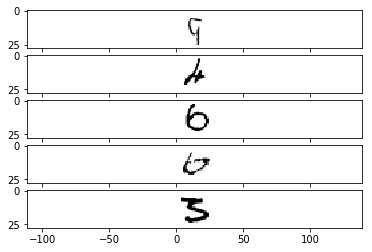

In [20]:
import matplotlib.pyplot as plt
%matplotlib inline

np.set_printoptions(precision=2)
np.set_printoptions(linewidth=1000)

i=0
maxi=5

f, plot = plt.subplots(maxi, sharex=True, sharey=True)

print("True - Mispredicted (prob)")

for img, label in zip(test_images, test_labels):
    if i==maxi:
        break
    img1 = np.expand_dims(img, axis=0)
    if np.argmax(model.predict(img1)) != np.argmax(label):
        img = np.reshape(img, (28,28))
        ind = np.argmax(model.predict(img1))
        print("%d - %d (%.2f)"%(np.argmax(label), ind, model.predict(img1)[0][ind]))
        plot[i].imshow(img, cmap="Greys")
        i+=1

![imagenet](images/results_imagenet.png)

## LeNet-5 (1998)
![LeNet](images/LeNet-5_1998.png)

## AlexNet (2012)
![AlexNet](images/AlexNet_2012.png)

## ZFNet (2013)
![ZFNet](images/ZFNet_2013.png)

## GoogleNet/Inception (2014)
![Inception](images/GoogleNet_Inception_2014.png)

## VGGNet (2014)
![VGGNet](images/VGGNet_2014.png)

## ResNet (2015)
![ResNet](images/ResNet_2015.png)

![results](images/results_weights.png)